# TP2 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

## Parte 1

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz,  graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque

In [152]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List

from utils.utils import plot_video_quality_measure
from utils.utils import draw_image_detection_none, draw_image_detection_roi, draw_image_detection_matrix

GridSize = Tuple[int, int]

In [153]:
# definiciones generales

video_path = 'enunciado/focus_video.mov'

A continuación vamos a definir la funcion `calculate_image_quality_measure` basado en el algoritmo que se visualiza en la imagen a continuación que pertenece al paper *Image Sharpness Measure for Blurred Images in Frequency Domain*

![Algoritmo Propuesto de FM](enunciado/proposed_algorithm.png)

In [154]:
# Declaración de la función `calculate_image_quality_measure` 
def calculate_image_quality_measure(image: np.ndarray) -> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) basada en la Medida de Desenfoque en el Dominio de Frecuencia.
    Esta función calcula el valor FM para una imagen en escala de grises usando.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.

    return:
        float: The Image Quality Measure (FM) of the input image.
        
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm = calculate_image_quality_measure(image)
    >>> print(f"Image Quality Measure (FM): {fm}")
    """

    # Step 1: Computar la transformada de Fourier de la imagen
    F = np.fft.fft2(image)

    # Step 2: Shift the zero-frequency component to the center of the spectrum
    Fc = np.fft.fftshift(F)

    # Step 3: Calcular el valor absoluto de la transformada de Fourier centrada
    AF = np.abs(Fc)

    # Step 4: Calcular el valor máximo de AF
    M = np.max(AF)

    # Step 5: Calcular T_H
    thres = M / 1000
    T_H = np.sum(AF > thres)

    # Step 6: Calcular la medida de calidad de imagen (FM)
    FM = T_H / (image.shape[0] * image.shape[1])

    return FM

In [155]:
def calculate_video_quality_measure(video_path_input:str, calculate_image_quality_measure_funtion:callable, **kwargs) -> list:
    """
    Analiza un video para calcular la Medida de Calidad de Imagen (FM) en cada frame.
    Aplicandose de acuerdo a la función `calculate_image_quality_measure_funtion`

    args:
        video_path (str): Path to the video file.
        calculate_image_quality_measure_funtion (callable): Function to calculate the Image Quality Measure (FM) of an image.
        **kwargs: Arbitrary keyword arguments.
    
    return:
        list: List of Image Quality Measures (FM) for each frame in the video.
    """

    cap = cv.VideoCapture(video_path)
    quality_measures = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        fm = calculate_image_quality_measure_funtion(gray, **kwargs)  # Pasar los kwargs a la función de cálculo
        quality_measures.append(fm)

    cap.release()
    cv.destroyAllWindows()
    return quality_measures

In [156]:
def create_video_quality_measure(video_path_input:str, video_path_output:str, threshold: float, quality_measure_graph: callable, quality_measure_list: list, **kwargs) -> None:
    """
    Analiza un video para calcular la Medida de Calidad de Imagen (FM) en cada frame.
    Aplicandose de acuerdo a la función `calculate_image_quality_measure_funtion`

    args:
        video_path (str): Path to the video file.
        calculate_image_quality_measure_funtion (callable): Function to calculate the Image Quality Measure (FM) of an image.
        **kwargs: Arbitrary keyword arguments.
    
    return:
        list: List of Image Quality Measures (FM) for each frame in the video.
    """

    cap = cv.VideoCapture(video_path)

    shape_image = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))

    fourcc = cv.VideoWriter_fourcc(*'XVID')
    out = cv.VideoWriter(video_path_output, fourcc, 20.0, shape_image)

    for i in range(len(quality_measure_list)):
        ret, frame = cap.read()
        if not ret:
            AssertionError("Diferente cantidad de frames en el video y en la lista de medidas de calidad")
        
        color = (0, 0, 255) if quality_measure_list[i] < threshold else (0, 255, 0)
        
        cv.putText(frame, f"FM: {quality_measure_list[i]:.4f}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        frame = quality_measure_graph(frame, shape_image, color, **kwargs)

        out.write(frame)

    cap.release()
    out.release()


### Medición sobre todo el frame.

In [157]:
# parametros de entrada
threshold=0.025

In [158]:
quality_measures_all_frame = calculate_video_quality_measure(video_path, calculate_image_quality_measure)

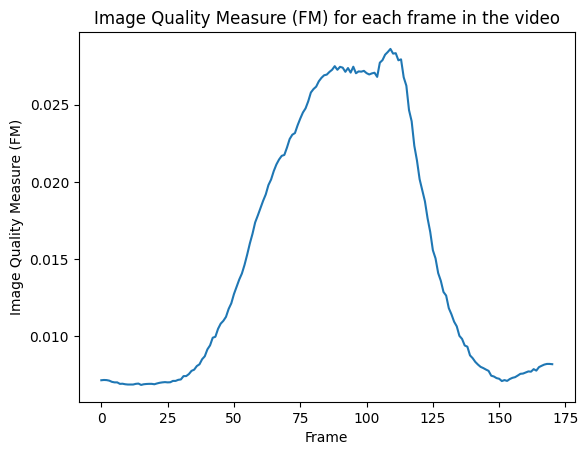

In [159]:
plot_video_quality_measure(quality_measures_all_frame)

In [160]:
create_video_quality_measure(video_path, 'output_video/quality_measure_all_frame.avi', threshold, draw_image_detection_none, quality_measures_all_frame)

### Medición sobre un ROI

In [161]:
# Función para Medir ROI en el Centro del Frame

def calculate_image_quality_measure_roi(image: np.ndarray, roi_percentage:float=0.1)-> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) para una región de interés (ROI) de la imagen.
    La ROI se define como un porcentaje del tamaño total de la imagen, centrada en el medio.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.
        roi_percentage (float): The percentage of the image dimensions to define the ROI.
                                Default is 0.1 (10% of the image dimensions).

    return:
        float: The Image Quality Measure (FM) of the ROI of the input image.
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm_roi = calculate_roi_quality_measure(image, roi_percentage=0.1)
    >>> print(f"ROI Image Quality Measure (FM): {fm_roi}")
    """
    # Obtener las dimensiones de la imagen
    height, width = image.shape
    
    # Calcular las dimensiones de la ROI
    roi_height = int(height * roi_percentage)
    roi_width = int(width * roi_percentage)
    
    # Calcular las coordenadas de la ROI centrada
    y1 = height // 2 - roi_height // 2
    y2 = y1 + roi_height
    x1 = width // 2 - roi_width // 2
    x2 = x1 + roi_width
    
    # Extraer la ROI de la imagen
    roi = image[y1:y2, x1:x2]

    # Calcular la medida de calidad de imagen para la ROI
    return calculate_image_quality_measure(roi)

In [162]:
#parametros para la función de ROI
roi_percentage = 0.2
threshold = 0.4

In [163]:
quality_measures_roi = calculate_video_quality_measure(video_path, calculate_image_quality_measure_roi, roi_percentage=roi_percentage)

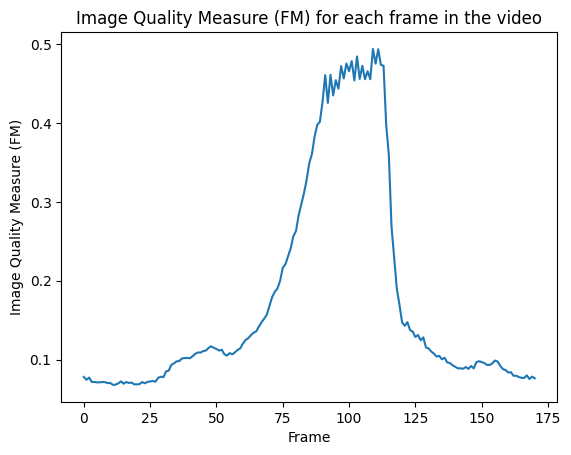

In [164]:
plot_video_quality_measure(quality_measures_roi)

In [165]:
create_video_quality_measure(video_path, 'output_video/quality_measure_roi.avi', threshold, draw_image_detection_roi, quality_measures_roi, roi_percentage=roi_percentage)

NameError: name 'cv' is not defined

### Medición sobre una matriz de enfoque

In [ ]:
def calculate_image_quality_measure_matrix(image: np.ndarray, grid_size: GridSize, scale_factor: float = 1.0) -> List[float]:
    """
    Calcula la Medida de Calidad de Enfoque (FM) en una matriz de sub-imágenes dentro de la imagen original.
    La imagen se divide en una grilla especificada por `grid_size` y se calcula la FM para cada sub-imagen.

    Args:
        image (np.ndarray): Imagen de entrada en escala de grises, representada como un array 2D de NumPy.
        grid_size (GridSize): Tamaño de la grilla para dividir la imagen (filas, columnas).
        scale_factor (float): Factor de escala para ajustar el tamaño de la grilla. Default es 1.0.

    Returns:
        List[float]: Lista de valores FM calculados para cada sub-imagen en la grilla.
        
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> grid_size = (4, 4)  # Dividir la imagen en una grilla de 4x4
    >>> fm_values = calculate_focus_matrix_quality_measure(image, grid_size, scale_factor=1.0)
    >>> print(f"Focus Matrix Quality Measures: {fm_values}")
    """

    height, width = image.shape
    rows, cols = grid_size
    
    # Calcular el tamaño ajustado de la grilla basado en el factor de escala
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)
    
    step_y = scaled_height // rows
    step_x = scaled_width // cols
    
    fm_values = []
    
    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (scaled_height // 2)
    start_x = center_x - (scaled_width // 2)
    
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values

In [ ]:
# Parámetros para la función de matriz
grid_sizes = [(3, 3), (7,5), (4,4), (5,5)]
scale_factor = 0.7
threshold = [0.2,0.3,0.25,0.3]

Grid Size: (3, 3)


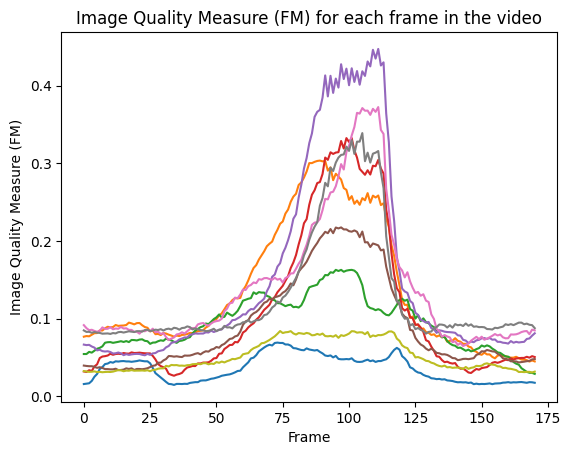

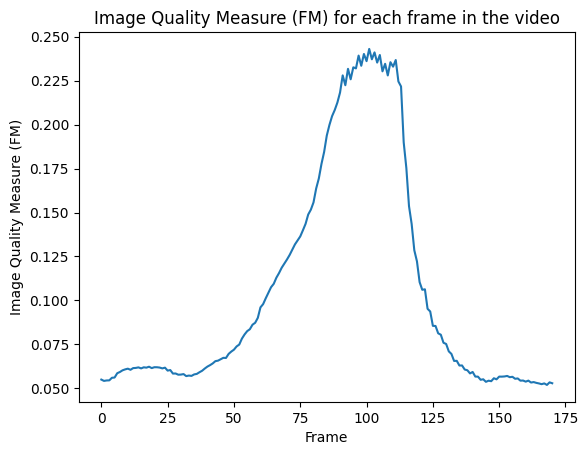

Grid Size: (7, 5)


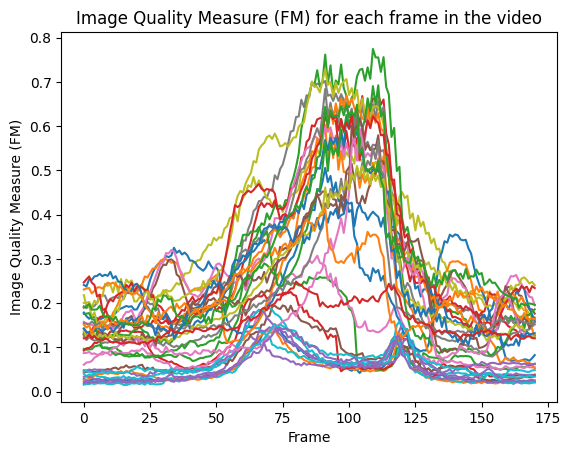

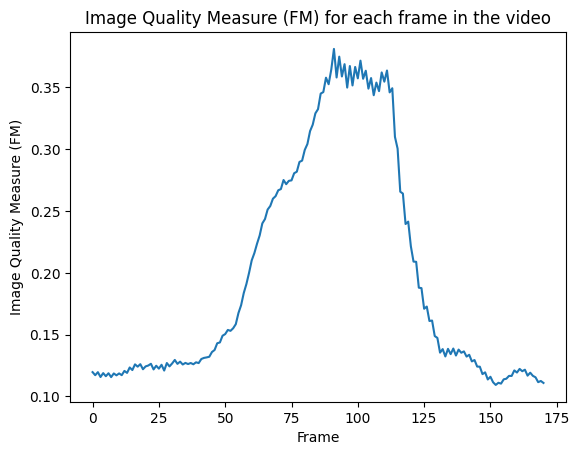

Grid Size: (4, 4)


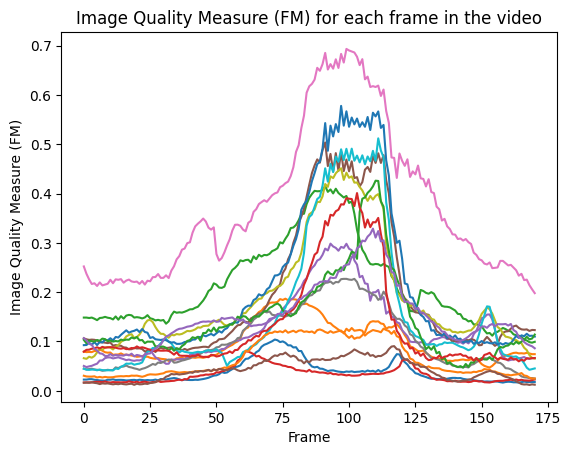

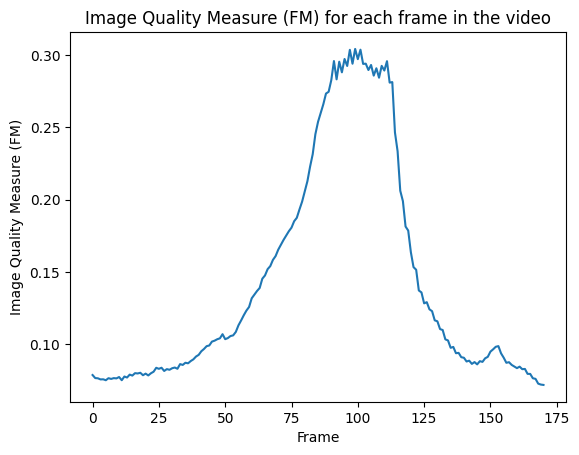

Grid Size: (5, 5)


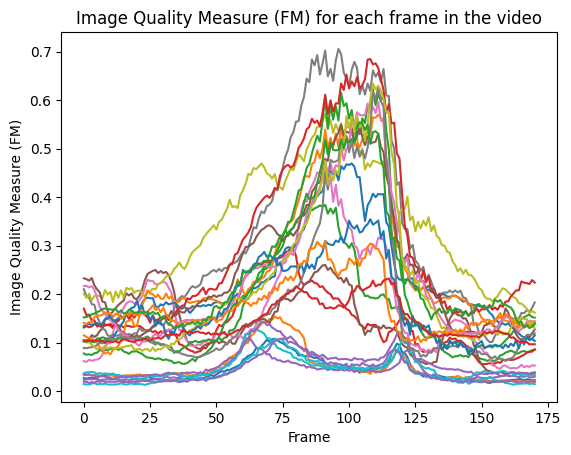

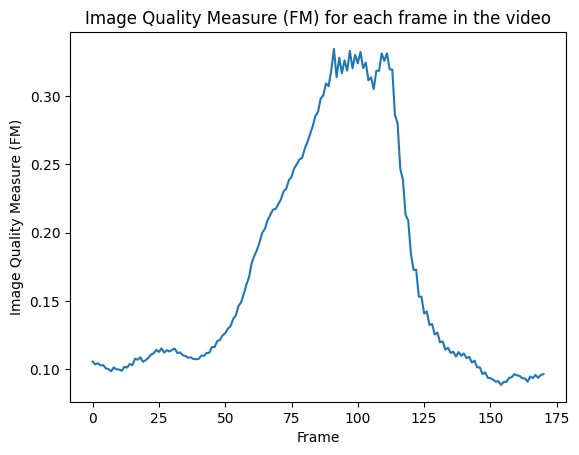

In [ ]:
for index in range(len(grid_sizes)):
    print(f"Grid Size: {grid_sizes[index]}")
    quality_measures_matrix = calculate_video_quality_measure(video_path, calculate_image_quality_measure_matrix, grid_size=grid_sizes[index], scale_factor=scale_factor)

    plot_video_quality_measure(quality_measures_matrix)

    quality_measures_matrix_one = np.mean(quality_measures_matrix, axis=1) #TODO: Cambiar metodo de promedio?

    plot_video_quality_measure(quality_measures_matrix_one) 

    create_video_quality_measure(video_path, f'output_video/quality_measure_matrix_{grid_sizes[index]}.avi', threshold[index], draw_image_detection_matrix, quality_measures_matrix_one, grid_size=grid_sizes[index], scale_factor=scale_factor)

## Parte 2

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus. El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [ ]:
def modified_laplacian_focus_measure(image: np.ndarray) -> np.float64:
    """Implementación de la medida de enfoque de Laplaciano modificado LAP2
    de Nayar.

    Args:
        image (np.ndarray): Imagen de entrada en escala de grises.

    Returns:
        np.float64: Medida de enfoque de la imagen.
    """
    # Definir las máscaras de convolución
    Lx = np.array([[-1, 2, -1]])
    Ly = Lx.T

    # Aplicar las convoluciones
    Ix = cv.filter2D(image, -1, Lx)
    Iy = cv.filter2D(image, -1, Ly)

    # Calcular el Laplaciano modificado
    laplacian_modified = np.abs(Ix) + np.abs(Iy)

    # Calcular la medida de enfoque
    focus_measure = np.mean(laplacian_modified)

    return focus_measure

In [ ]:
#parametros para la función de ROI
threshold = 2

In [ ]:
quality_measures_laplacian = calculate_video_quality_measure(video_path, modified_laplacian_focus_measure)

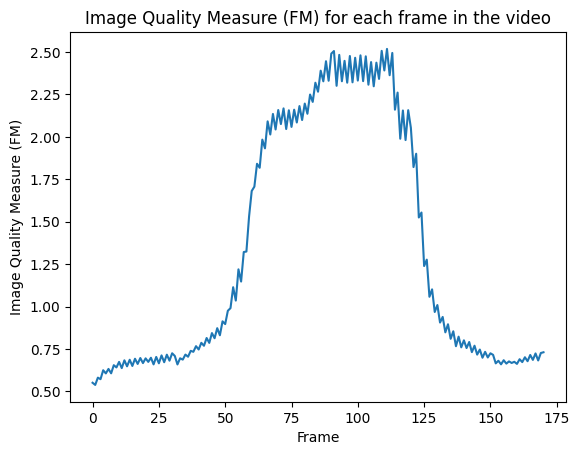

In [ ]:
plot_video_quality_measure(quality_measures_laplacian)

In [ ]:
create_video_quality_measure(video_path, 'output_video/quality_measure_laplacian.avi', threshold, draw_image_detection_none, quality_measures_laplacian)

# Parte extra

Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [ ]:
def unsharp_masking(image, kernel_size=(5, 5), sigma=1.0, amount=1):
    # Desenfocar la imagen
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    
    # Calcular la máscara
    mask = image - blurred
    
    # Aplicar la máscara a la imagen original
    sharpened = np.clip(image + amount * mask, 0, 255).astype(np.uint8)

    return sharpened

In [ ]:
# aplicar unsharp masking a un video
# Leer el video
video = cv.VideoCapture('enunciado\\focus_video.mov')

# Crear el video de salida
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output_video\\unsharp_masking.avi', fourcc, 30.0, (640, 360))

k = 10

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    frame = frame.astype(np.float32)

    unsharp = unsharp_masking(frame,amount=k)

    out.write(unsharp)

video.release()
out.release()
cv.destroyAllWindows()

In [ ]:
roi_percentage = 0.2

In [ ]:
quality_measures_with_unsharp = calculate_video_quality_measure('output_video\\unsharp_masking.avi', calculate_image_quality_measure_roi, roi_percentage=roi_percentage)

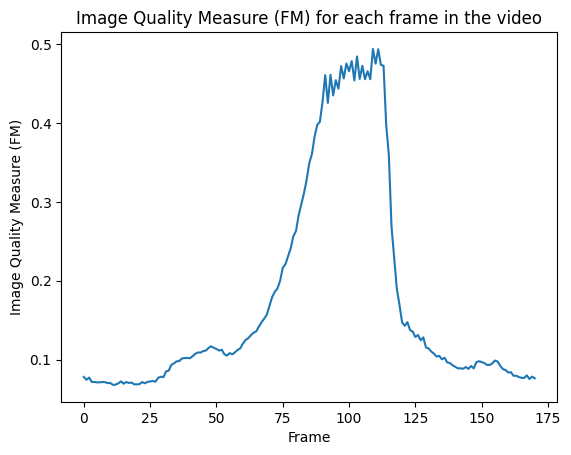

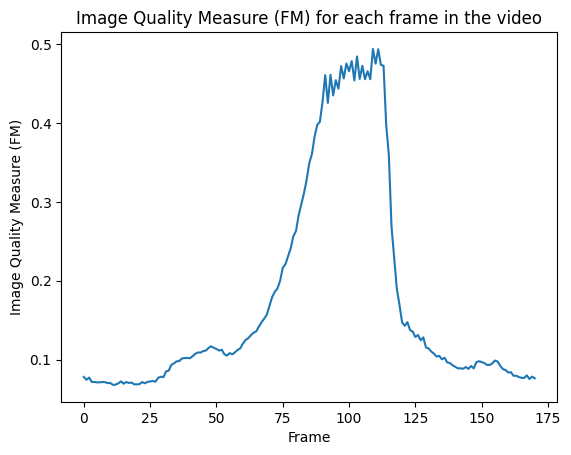

In [ ]:
plot_video_quality_measure(quality_measures_with_unsharp)
plot_video_quality_measure(quality_measures_roi)